In [1]:
import pandas as pd
import re

In [2]:
genmap2 = pd.read_csv('/home/vpt/data/omim/20190718/genemap2.txt',sep ='\t',skiprows=3,dtype={'Entrez Gene ID':str,'Mim Number':str})
genmap2['Mim Number'] = 'OMIM:'+genmap2['Mim Number']
genmap2.index = genmap2['Entrez Gene ID']
genmap2 = genmap2[~genmap2.index.isnull()]
genmap2 = genmap2[~genmap2.Phenotypes.isnull()]   # quito genes sin phenotype omim
autosomal = genmap2[genmap2.Phenotypes.str.contains('autosomal',flags=re.IGNORECASE, regex=True).fillna(False)]


# get phenotype ids form Phenotypes field

In [3]:
expanded = autosomal.Phenotypes.str.split(';',expand = True)

phenoid = []
for g in expanded.index:
    df =expanded.loc[g,:].str.extract('([0-9]{6})')
    df.columns = [g]
    phenoid.append(df)
pheno_id = pd.concat(phenoid,1).transpose()

# este enfoque mas simple y rapido falló  porque algunos fenotipos estan sin ID, 
# generan nulls y descoordinan el match con el parseo de AR/AD/ADAR 

#pheno_id = expanded.apply(lambda x: x.str.extractall('([0-9]{6})')[0].values,axis = 1)  
#pheno_id = expanded.apply(lambda x: x.str.extract('([0-9]{6})')[0].values,axis = 1)




In [4]:
inhAD = expanded.apply(lambda x: x.str.contains(pat = '(Autosomal dominant)',flags = re.IGNORECASE))#[0].values,axis = 1)
inhAR = expanded.apply(lambda x: x.str.contains(pat = '(Autosomal recessive)',flags = re.IGNORECASE))*10
encode_inherit = inhAD + inhAR
decode_inherit = {11:'AD|AR',10:'AR',1:'AD',0:None}
inheritance = encode_inherit.replace(decode_inherit)
#inheritance = inheritance.apply(lambda x: x[~x.isnull()].to_list(),axis = 1)

/home/vpt/venvs/py3/lib/python3.5/site-packages/ipykernel_launcher.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """Entry point for launching an IPython kernel.
/home/vpt/venvs/py3/lib/python3.5/site-packages/ipykernel_launcher.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  


In [5]:
tiene_phenotype = pheno_id.isnull().all(1)
tiene_autosomal = inheritance.isnull().all(1)
ok = (~tiene_autosomal)&(~tiene_phenotype)  # me aseguro que tenga  phenotype id y algun flag de AUTOSOMAL D o R

phenotype_inherit = (pheno_id[ok] + ':' + inheritance[ok]).apply(lambda x: x[~x.isnull()].to_list(),axis = 1)
mapa = []

for g in phenotype_inherit.index:
    mapp = pd.Series(phenotype_inherit.loc[g]).str.split(':',expand = True)
    mapp.columns= ['OMIM:ID','Inheritance']
    mapp['gene'] = g
    mapa.append(mapp)
map_phenotypeID_inheritance_gene =  pd.concat(mapa)

In [6]:
map_phenotypeID_inheritance_gene.Inheritance.value_counts(dropna=False)

AR       2846
AD       2438
AD|AR     194
Name: Inheritance, dtype: int64

In [603]:
## este numero es restringido a los genes ADAR 
#map_phenotypeID_inheritance_gene.Inheritance.value_counts(dropna=False)

AD      572
AR      421
ADAR    194
Name: Inheritance, dtype: int64

In [7]:
map_phenotypeID_inheritance_gene.head()

,OMIM:ID,Inheritance,gene
0,155600,AD,1243
0,115665,AD,7792
0,608995,AD,406874
0,616126,AR,9636
0,615120,AR,375790


In [8]:
map_phenotypeID_inheritance_gene.to_csv('/home/vpt/data/omim/20190718/map_phenotypeID_inheritanceMode_entrez.tsv',sep = '\t')

### Match with clinvar

In [9]:
import pandas as pd
import re
import numpy as np

In [10]:
clinvarTSV = pd.read_csv('/home/vpt/data/clinvar/clinvar_tsv20190624/clinvar_variant_summary_20190624.txt.gz',sep = '\t')
clinvar_omim = clinvarTSV[clinvarTSV.PhenotypeIDS.str.contains('OMIM')]
clinvar_omim_unique = clinvar_omim.drop_duplicates(subset = ['VariationID','PhenotypeIDS'])
clinvar_omim_unique.index = clinvar_omim_unique.VariationID

/home/vpt/venvs/py3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [11]:
omims = clinvar_omim_unique.PhenotypeIDS.str.extractall('(OMIM:[0-9]{6})') ## esto multiplica filas x multiples maches
omims_per_variant = omims.reset_index().groupby(['VariationID'])[0].agg(lambda col: ';'.join(col))
clinvar_omim_unique['OMIM_phenotypeIDs'] = omims_per_variant

# approach descartado; esto te trae los ids de medgen tambien por el separador de campo utilizado

##split_pheno = clinvar_omim_unique.PhenotypeIDS.str.split(',')
##split_pheno.head().values
##omims = split_pheno.apply(lambda x: ','.join([a for a in x if 'OMIM' in a ]))  ## 


/home/vpt/venvs/py3/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


# Creo un mapa para imputar AR / AD o AD-AR 

In [52]:
auxiliar_map = map_phenotypeID_inheritance_gene.copy()
auxiliar_map['OMIM:ID'] = 'OMIM:'+map_phenotypeID_inheritance_gene['OMIM:ID']
auxiliar_map.index = auxiliar_map['OMIM:ID']
omimdict = auxiliar_map['Inheritance'].to_dict()

##  'autosomal' Phenotypes

In [53]:
clinvar_expanded_phenotypeIDs = clinvar_omim_unique['OMIM_phenotypeIDs'].str.split(';',expand = True)
a =clinvar_expanded_phenotypeIDs.values.ravel()# .isin(list(omimdict.keys())
ids = np.unique(a[a != None])
autosomal_phenotypes = ids[(pd.Series(ids).isin(list(omimdict.keys())))]
autosomal_phenotypes.shape

(4492,)

## other phenotypes are from two clases: 
 * UNKNOWN or other rather AUTOSOMAL

In [54]:
other_phenotypes = ids[~(pd.Series(ids).isin(list(omimdict.keys())))]
other_phenotypes.shape 


(1077,)

## amplio el diccionario con los fenotipos no autosomicos o de herencia desconocida

In [55]:
for i in other_phenotypes:
    omimdict.update({i:'other/unknown'})

###  imputo AD, AR, AD|AR 

In [56]:
# esto es infinitamente mas rapido que un replace!!
clinvar_inheritance = clinvar_expanded_phenotypeIDs.copy()
for i in clinvar_inheritance.columns:
    clinvar_inheritance[i] = clinvar_inheritance[i].map(omimdict)


In [88]:
AR = (clinvar_inheritance == 'AR').any(1)
AD = 10*(clinvar_inheritance == 'AD').any(1)
ADAR = 100*(clinvar_inheritance == 'AD|AR').any(1)
OTHER = 1000*(clinvar_inheritance == 'other/unknown').any(1)
inheritance_flag = AR + AD + ADAR + OTHER


In [104]:
inheritance_veredict = pd.Series(['veredict']*len(inheritance_flag),index = inheritance_flag.index)
inheritance_veredict[(inheritance_flag==1).values] = 'AR'
inheritance_veredict[(inheritance_flag==10).values] = 'AD'
inheritance_veredict[((inheritance_flag >10) & (inheritance_flag <1000)).values] = 'AD|AR'
inheritance_veredict[(inheritance_flag>=1000).values] = 'other/unknown'

In [105]:
inheritance_veredict.value_counts()

AD               92406
AR               85111
other/unknown    33554
AD|AR            14176
dtype: int64

In [107]:
clinvar_omim_unique['inheritance_omim'] =  inheritance_veredict
clinvar_omim_unique.inheritance_omim.value_counts(dropna = False)

/home/vpt/venvs/py3/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


AD               92406
AR               85111
other/unknown    33554
AD|AR            14176
Name: inheritance_omim, dtype: int64

## restringido a pathogenicas

In [113]:
clinvar_omim_unique[['ClinSigSimple','ClinicalSignificance']].head(10)

,ClinSigSimple,ClinicalSignificance
VariationID,,
2,1,Pathogenic
3,1,Pathogenic
4,0,Uncertain significance
5,1,Pathogenic
6,1,Pathogenic
214885,0,Uncertain significance
8,1,Pathogenic
9,1,"Conflicting interpretations of pathogenicity, ..."
10,1,"Pathogenic, other, risk factor"


In [111]:
clinvar_omim_unique.groupby(['ClinSigSimple'])['inheritance_omim'].value_counts()

ClinSigSimple  inheritance_omim
-1             AR                    157
               AD                     79
               other/unknown          45
               AD|AR                   7
 0             AD                  63193
               AR                  55205
               other/unknown       22219
               AD|AR               11292
 1             AR                  29749
               AD                  29134
               other/unknown       11290
               AD|AR                2877
Name: inheritance_omim, dtype: int64

In [115]:
clinvar_omim_unique.to_csv('/home/vpt/data/clinvar/clinvar_tsv20190624/clinvar_omim_unique_with_inheritance.tsv',
                           sep = '\t',index = False)

## hay que splitear Other of Unknown!!! 

In [116]:
from matplotlib_venn import venn2, venn2_circles
from matplotlib_venn import venn3, venn3_circles
from matplotlib import pyplot as plt

In [117]:
clinvarAD = pd.read_csv('/home/vpt/data/clinvar/clinvar_omim_by_GEN/AD-clinvarOMIM.tsv',sep ='\t')
print(clinvarAD.shape[0])
clinvarAR  = pd.read_csv('/home/vpt/data/clinvar/clinvar_omim_by_GEN/AR-clinvarOMIM.tsv',sep ='\t')
print(clinvarAR.shape[0])
clinvarBOTH  = pd.read_csv('/home/vpt/data/clinvar/clinvar_omim_by_GEN/ADAR-clinvarOMIM.tsv',sep ='\t')
print(clinvarBOTH.shape[0])


76068
69809
49777


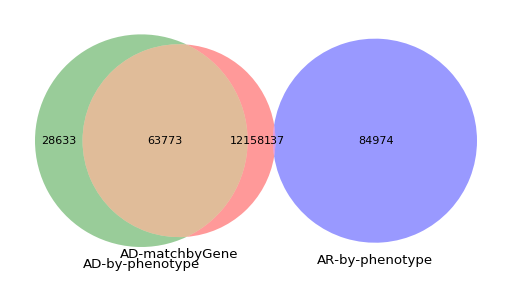

In [119]:
fig=plt.figure(figsize=(8, 8), dpi= 80, facecolor='w', edgecolor='k')
venn3([set(clinvarAD.VariationID.values),
     set(clinvar_omim_unique[clinvar_omim_unique.inheritance_omim=='AD'].VariationID.values),
     set(clinvar_omim_unique[clinvar_omim_unique.inheritance_omim=='AR'].VariationID.values)],
      set_labels = ('AD-matchbyGene', 'AD-by-phenotype','AR-by-phenotype'))

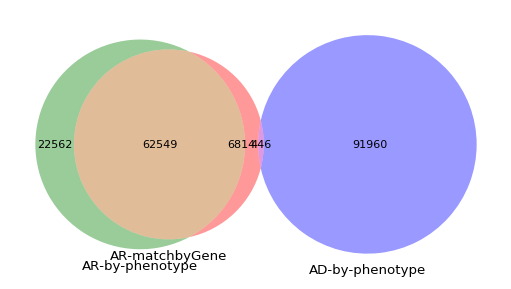

In [130]:
fig=plt.figure(figsize=(8, 8), dpi= 80, facecolor='w', edgecolor='k')
venn3([set(clinvarAR.VariationID.values),
     set(clinvar_omim_unique[clinvar_omim_unique.inheritance_omim=='AR'].VariationID.values),
     set(clinvar_omim_unique[clinvar_omim_unique.inheritance_omim=='AD'].VariationID.values)],
      set_labels = ('AR-matchbyGene', 'AR-by-phenotype','AD-by-phenotype'))

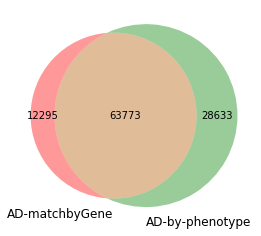

In [126]:
venn2([set(clinvarAD.VariationID.values),
     set(clinvar_omim_unique[clinvar_omim_unique.inheritance_omim=='AD'].VariationID.values),
     ],
      set_labels = ('AD-matchbyGene', 'AD-by-phenotype'))

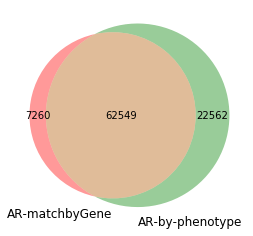

In [131]:
venn2([set(clinvarAR.VariationID.values),
     set(clinvar_omim_unique[clinvar_omim_unique.inheritance_omim=='AR'].VariationID.values),
     ],
      set_labels = ('AR-matchbyGene', 'AR-by-phenotype'))

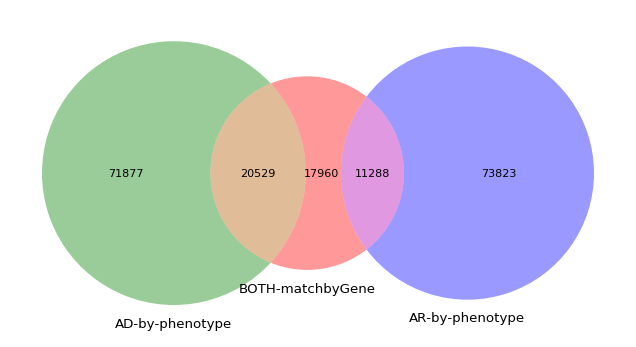

In [203]:
fig=plt.figure(figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')
v =venn3([set(clinvarBOTH.VariationID.values),
     set(clinvar_omim_unique[clinvar_omim_unique.inheritance_omim=='AD'].VariationID.values),
     set(clinvar_omim_unique[clinvar_omim_unique.inheritance_omim=='AR'].VariationID.values)],
      set_labels = ('BOTH-matchbyGene', 'AD-by-phenotype','AR-by-phenotype'))
v.subset_labels[0] = plt.Text(0.02453599008633018, 0.2, '17960')

plt.show(v)


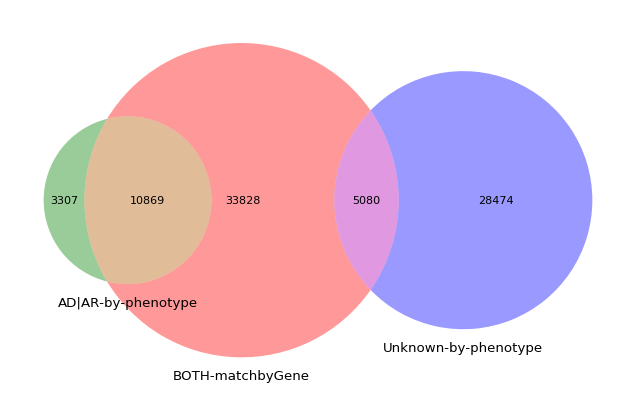

In [205]:
fig=plt.figure(figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')
v =venn3([set(clinvarBOTH.VariationID.values),
     set(clinvar_omim_unique[clinvar_omim_unique.inheritance_omim=='AD|AR'].VariationID.values),
     set(clinvar_omim_unique[clinvar_omim_unique.inheritance_omim=='other/unknown'].VariationID.values)],
      set_labels = ('BOTH-matchbyGene', 'AD|AR-by-phenotype','Unknown-by-phenotype'))
v.subset_labels[0] = plt.Text(0.02453599008633018, 0.2, '17960')

plt.show(v)
